# Merge and EDA of weather-energy datasets

# 1. import and check

In [1]:
import pandas as pd

In [2]:
energy_data = pd.read_csv('../data/processed data/processed_energy_data.csv')
weather_data = pd.read_csv('../data/processed data/processed_weather_data.csv')

In [3]:
energy_data.head(3)

,date,mean_consumption,median_consumption,std_consumption,day,holiday
0,2011-11-23,7.063833,6.2460,5.373299,2,0
1,2011-11-24,8.426043,7.4890,6.219456,3,0
2,2011-11-25,9.350267,8.7385,6.377867,4,0


In [4]:
weather_data.head()

,ob_time,wind_direction,wind_speed,air_temperature,dewpoint,rltv_hum,prcp_amt
0,2011-11-23 00:00:00,270.0,1.0,4.6,4.0,95.2,0.0
1,2011-11-23 01:00:00,320.0,1.0,3.6,3.1,96.6,0.0
2,2011-11-23 02:00:00,310.0,2.0,3.7,3.3,96.6,0.0
3,2011-11-23 03:00:00,280.0,2.0,4.5,4.2,98.3,0.0
4,2011-11-23 04:00:00,240.0,2.0,2.4,2.0,96.4,0.0


In [5]:
weather_data["ob_time"] = pd.to_datetime(weather_data["ob_time"])

In [6]:
energy_data["date"] = pd.to_datetime(energy_data["date"])

# 2. Merging weather and energy data

In [7]:
min(weather_data['ob_time']), max(weather_data['ob_time'])

(Timestamp('2011-11-23 00:00:00'), Timestamp('2014-02-27 23:00:00'))

In [8]:
min(energy_data['date']), max(energy_data['date'])

(Timestamp('2011-11-23 00:00:00'), Timestamp('2014-02-27 00:00:00'))

In [9]:
energy_data= energy_data.iloc[:-1]

In [10]:
len(weather_data), len(energy_data)

(19872, 827)

In [11]:
# this length difference is because the weather data consits of data points of every hours
# So if we divide the length of weather data by 24 then, the dataset length must be equal
len(weather_data)/24, len(energy_data)

(828.0, 827)

We can't merge the datasets with diffrent lengths or different time format
Instead what seems to be best is do some aggregration and feature engineering on the weather data per day
To make it daily weather data from hourly data. for that, each of the parameters are engineered based on their nature

There are following parameters in weather data:
1. Time
2. Wind direction
3. Wind speed
4. Air temperature
5. Dewpoint
6. Relative humidity
7. Precipation amount

The following are the features that will be extracted from parameters:
1. **Mean**: wind speed, air temperature, dewpoint and relative humidity
2. **Median**: wind speed, air temperature, dewpoint and relative humidity
3. **Standard deviation**: wind speed, air temperature, dewpoint and relative humidity
4. **Minimum and Maximum**: wind speed, air temperature, dewpoint and relative humidity
5. **Sum**: Precipation
6. **Count > 0**: Precipation (This is for number of hours of precipation per day)
7. **Categorical feature**: For wind direction, which is categorical feature, the data in degrees will be convert to directions (E, W, N, S, NE, NW, SE, SW), and then the mode of the direction will be calculated to determine from which direction the wind is very frequent in a day

In [12]:
# Function to convert wind direction degrees to compass directions
def get_wind_direction(degree):
    degree = float(degree)
    if degree >= 0 and degree < 22.5:
        return 'N'
    elif degree >= 22.5 and degree < 67.5:
        return 'NE'
    elif degree >= 67.5 and degree < 112.5:
        return 'E'
    elif degree >= 112.5 and degree < 157.5:
        return 'SE'
    elif degree >= 157.5 and degree < 202.5:
        return 'S'
    elif degree >= 202.5 and degree < 247.5:
        return 'SW'
    elif degree >= 247.5 and degree < 292.5:
        return 'W'
    elif degree >= 292.5 and degree < 337.5:
        return 'NW'
    else:
        return 'N'

# Function to aggregate weather data
def aggregate_weather_data(weather_df):
    # Convert 'ob_time' to datetime and extract the date
    weather_df['ob_time'] = pd.to_datetime(weather_df['ob_time'])
    weather_df['date'] = weather_df['ob_time'].dt.date

    # Convert wind direction degrees to compass directions
    weather_df['wind_direction'] = weather_df['wind_direction'].apply(get_wind_direction)

    # Aggregate features per day
    aggregated_df = weather_df.groupby('date').agg(
        wind_speed_mean=('wind_speed', 'mean'),
        air_temperature_mean=('air_temperature', 'mean'),
        dewpoint_mean=('dewpoint', 'mean'),
        rltv_hum_mean=('rltv_hum', 'mean'),

        wind_speed_median=('wind_speed', 'median'),
        air_temperature_median=('air_temperature', 'median'),
        dewpoint_median=('dewpoint', 'median'),
        rltv_hum_median=('rltv_hum', 'median'),

        wind_speed_std=('wind_speed', 'std'),
        air_temperature_std=('air_temperature', 'std'),
        dewpoint_std=('dewpoint', 'std'),
        rltv_hum_std=('rltv_hum', 'std'),

        wind_speed_min=('wind_speed', 'min'),
        air_temperature_min=('air_temperature', 'min'),
        dewpoint_min=('dewpoint', 'min'),
        rltv_hum_min=('rltv_hum', 'min'),

        wind_speed_max=('wind_speed', 'max'),
        air_temperature_max=('air_temperature', 'max'),
        dewpoint_max=('dewpoint', 'max'),
        rltv_hum_max=('rltv_hum', 'max'),

        prcp_sum=('prcp_amt', 'sum'),
        prcp_count=('prcp_amt', lambda x: (x > 0).sum()),  # Count hours of precipitation
        wind_direction_mode=('wind_direction', lambda x: x.mode()[0])  # Most frequent wind direction
    ).reset_index()

    return aggregated_df


aggregated_weather = aggregate_weather_data(weather_data)

In [13]:
print(aggregated_weather.head(3))

         date  wind_speed_mean  air_temperature_mean  dewpoint_mean  \
0  2011-11-23         2.125000              5.925000       5.208333   
1  2011-11-24         4.333333              9.670833       8.041667   
2  2011-11-25         6.083333             10.541667       6.891667   

   rltv_hum_mean  wind_speed_median  air_temperature_median  dewpoint_median  \
0      95.250000                2.0                    6.15             5.95   
1      90.112500                4.0                    9.25             7.90   
2      78.779167                6.0                   11.45             5.65   

   rltv_hum_median  wind_speed_std  ...  air_temperature_min  dewpoint_min  \
0             97.0        0.612372  ...                  2.4           2.0   
1             90.2        1.711004  ...                  6.1           5.9   
2             83.6        2.185260  ...                  6.1           4.1   

   rltv_hum_min  wind_speed_max  air_temperature_max  dewpoint_max  \
0          

In [14]:
aggregated_weather.columns

Index(['date', 'wind_speed_mean', 'air_temperature_mean', 'dewpoint_mean',
       'rltv_hum_mean', 'wind_speed_median', 'air_temperature_median',
       'dewpoint_median', 'rltv_hum_median', 'wind_speed_std',
       'air_temperature_std', 'dewpoint_std', 'rltv_hum_std', 'wind_speed_min',
       'air_temperature_min', 'dewpoint_min', 'rltv_hum_min', 'wind_speed_max',
       'air_temperature_max', 'dewpoint_max', 'rltv_hum_max', 'prcp_sum',
       'prcp_count', 'wind_direction_mode'],
      dtype='object')

In [15]:
len(aggregated_weather)

828

In [16]:
# Ensure that both 'date' columns are in datetime format
energy_data['date'] = pd.to_datetime(energy_data['date']).dt.date
aggregated_weather['date'] = pd.to_datetime(aggregated_weather['date']).dt.date

# Merge the datasets on 'date' column
merged_data = pd.merge(aggregated_weather, energy_data, on='date', how='inner')

# Display the merged dataset
merged_data.head(3)

,date,wind_speed_mean,air_temperature_mean,dewpoint_mean,rltv_hum_mean,wind_speed_median,air_temperature_median,dewpoint_median,rltv_hum_median,wind_speed_std,...,dewpoint_max,rltv_hum_max,prcp_sum,prcp_count,wind_direction_mode,mean_consumption,median_consumption,std_consumption,day,holiday
0,2011-11-23,2.125000,5.925000,5.208333,95.250000,2.0,6.15,5.95,97.0,0.612372,...,7.8,98.6,0.0,0,SW,7.063833,6.2460,5.373299,2,0
1,2011-11-24,4.333333,9.670833,8.041667,90.112500,4.0,9.25,7.90,90.2,1.711004,...,10.4,98.6,0.4,2,S,8.426043,7.4890,6.219456,3,0
2,2011-11-25,6.083333,10.541667,6.891667,78.779167,6.0,11.45,5.65,83.6,2.185260,...,11.6,94.0,0.4,2,W,9.350267,8.7385,6.377867,4,0


In [17]:
merged_data.columns

Index(['date', 'wind_speed_mean', 'air_temperature_mean', 'dewpoint_mean',
       'rltv_hum_mean', 'wind_speed_median', 'air_temperature_median',
       'dewpoint_median', 'rltv_hum_median', 'wind_speed_std',
       'air_temperature_std', 'dewpoint_std', 'rltv_hum_std', 'wind_speed_min',
       'air_temperature_min', 'dewpoint_min', 'rltv_hum_min', 'wind_speed_max',
       'air_temperature_max', 'dewpoint_max', 'rltv_hum_max', 'prcp_sum',
       'prcp_count', 'wind_direction_mode', 'mean_consumption',
       'median_consumption', 'std_consumption', 'day', 'holiday'],
      dtype='object')

In [18]:
len(merged_data.columns)

29

# 3. Explore the dataset

In [19]:
# Fist correlation heatmap is plotted in order to narrow down investigatiom

In [20]:
correlation_columns = ['wind_speed_mean', 'air_temperature_mean', 'dewpoint_mean',
       'rltv_hum_mean', 'wind_speed_median', 'air_temperature_median',
       'dewpoint_median', 'rltv_hum_median', 'wind_speed_std',
       'air_temperature_std', 'dewpoint_std', 'rltv_hum_std', 'wind_speed_min',
       'air_temperature_min', 'dewpoint_min', 'rltv_hum_min', 'wind_speed_max',
       'air_temperature_max', 'dewpoint_max', 'rltv_hum_max', 'prcp_sum',
       'prcp_count', 'mean_consumption',
       'median_consumption', 'std_consumption']
correlation_matrix_df = merged_data[correlation_columns]

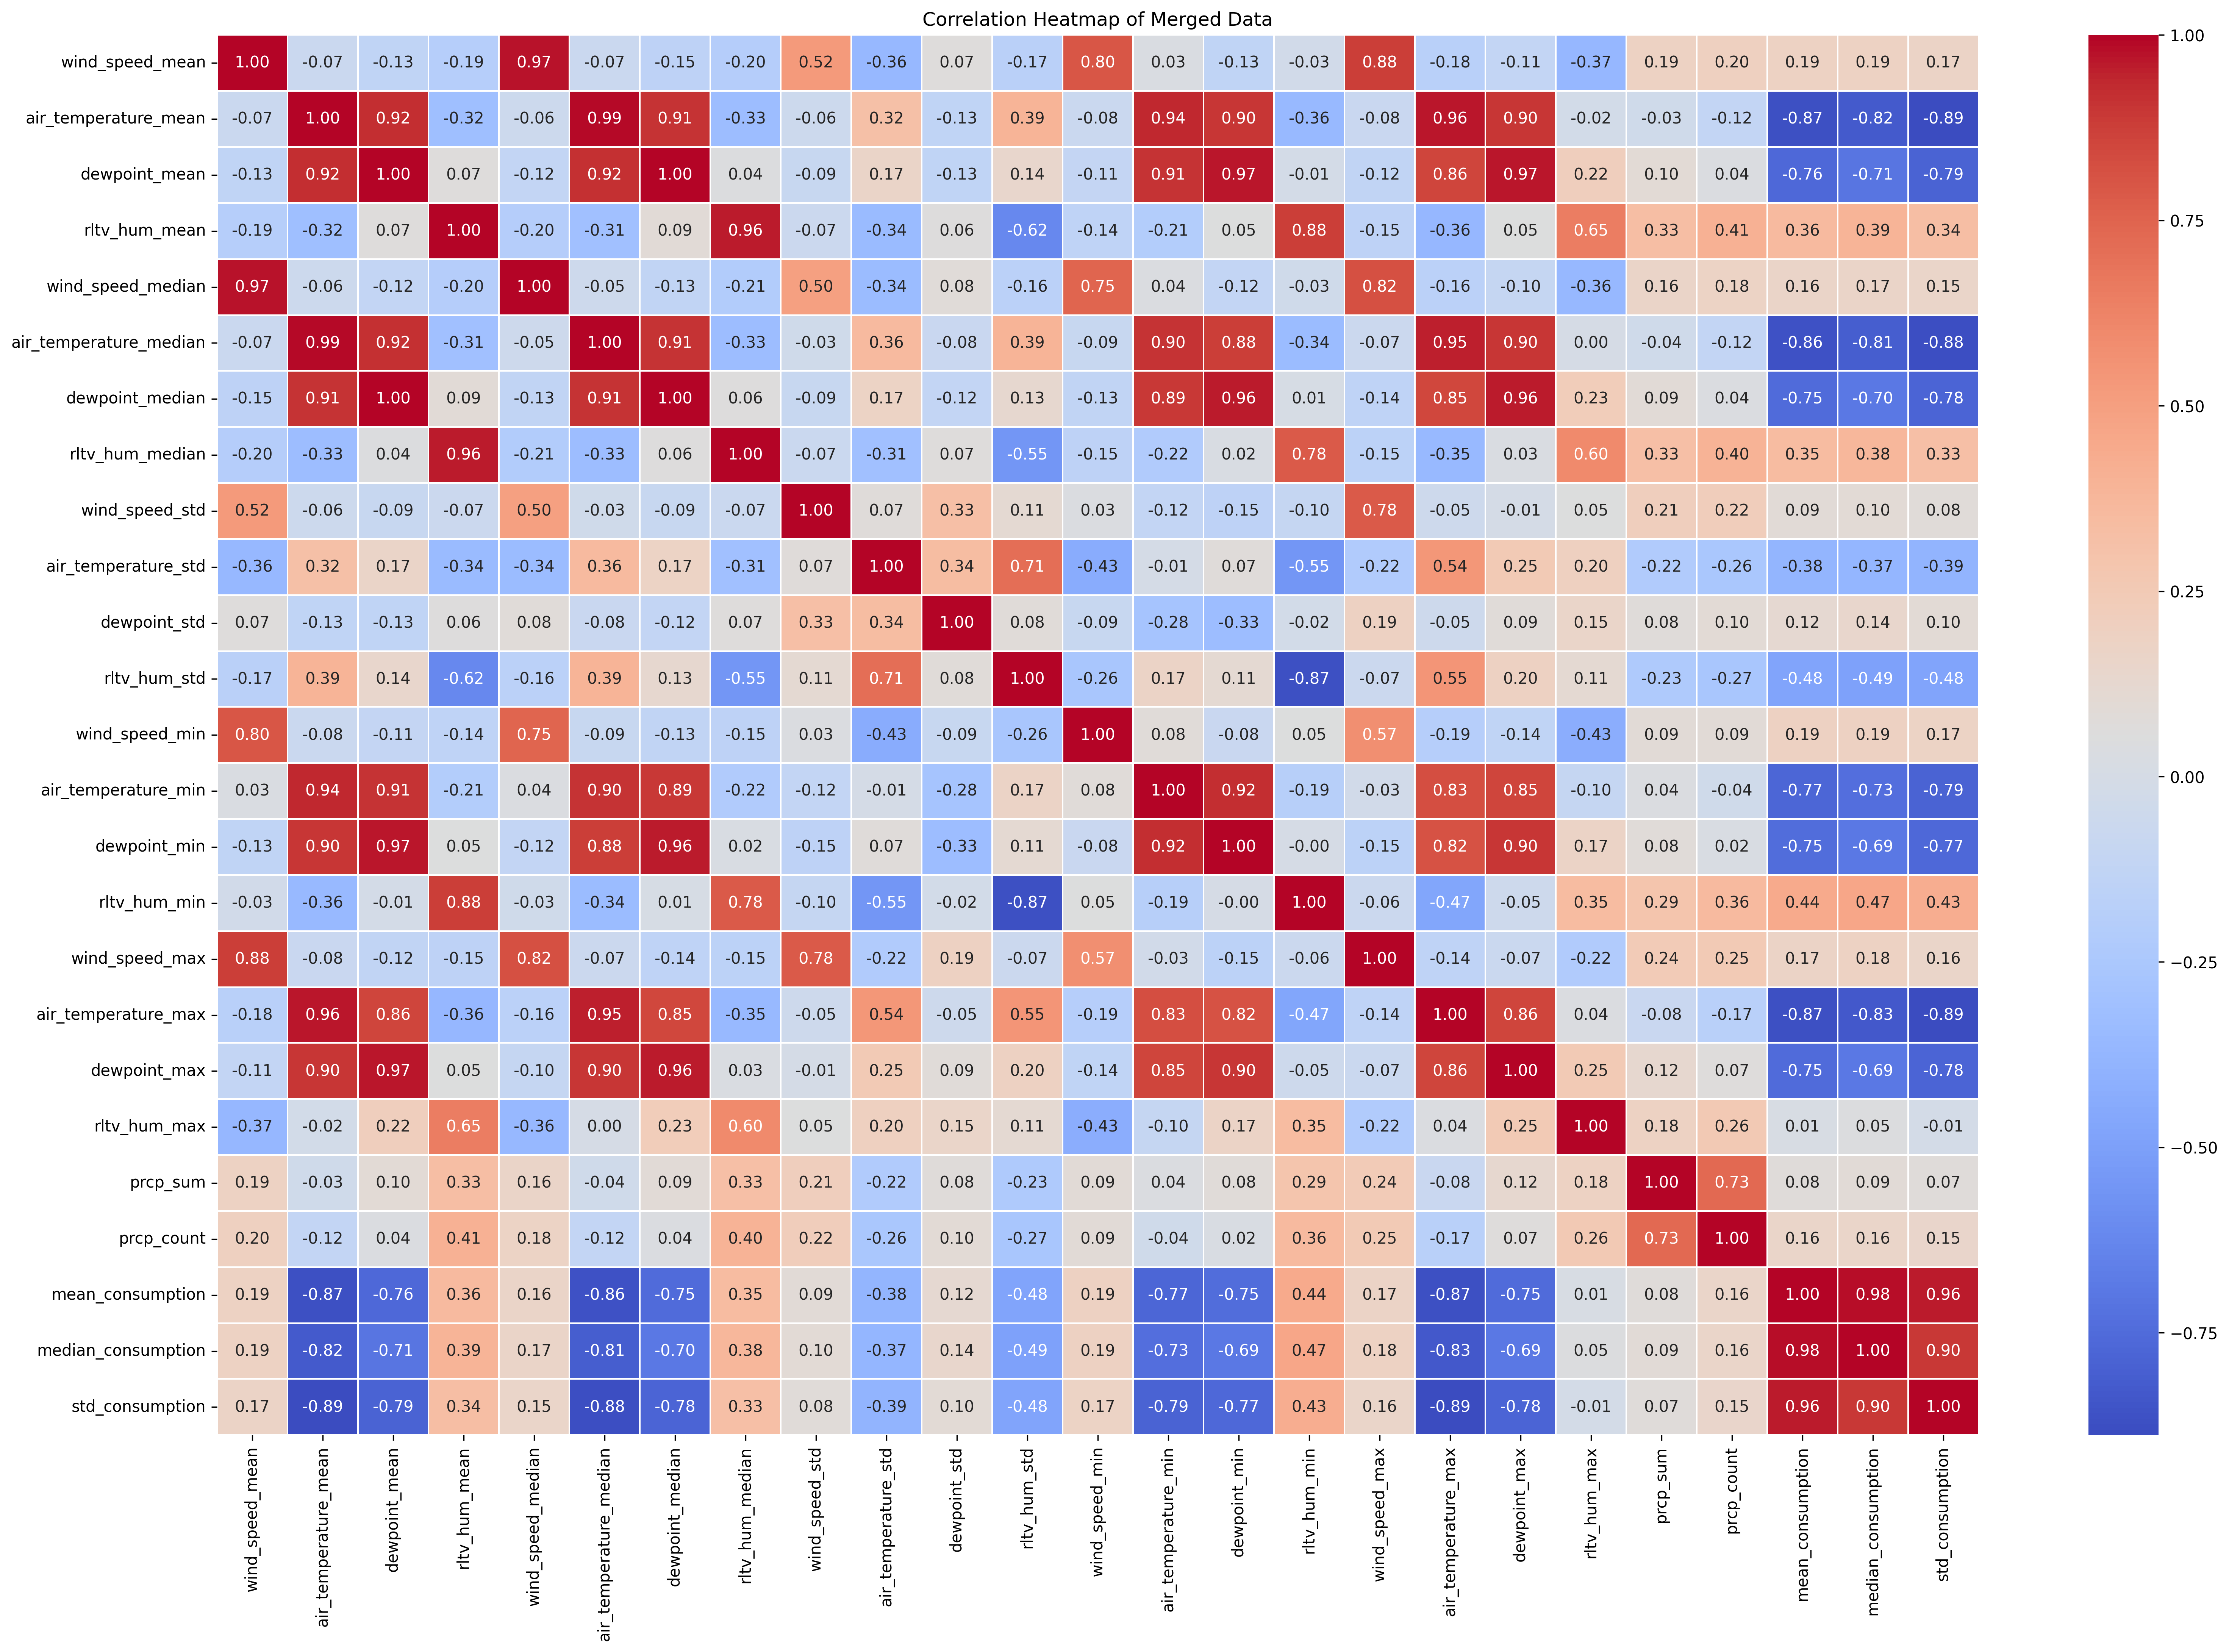

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = correlation_matrix_df.corr()

# Create the heatmap
plt.figure(figsize=(25,16), dpi =300)  # Adjust the figure size for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Display the plot
plt.title('Correlation Heatmap of Merged Data')
plt.show();


In [22]:
# Selecting the appropriate features that have potential of predicting the consumption by the correlation heatmap
selected_features = ['date','air_temperature_mean', 'dewpoint_mean',
       'rltv_hum_mean',
       'air_temperature_min', 'rltv_hum_min', 
       'air_temperature_max',
       'prcp_count', 'mean_consumption',
       'median_consumption', 'std_consumption']

In [23]:
feature_selected_data = merged_data[selected_features]
feature_selected_data.head()

,date,air_temperature_mean,dewpoint_mean,rltv_hum_mean,air_temperature_min,rltv_hum_min,air_temperature_max,prcp_count,mean_consumption,median_consumption,std_consumption
0,2011-11-23,5.925000,5.208333,95.250000,2.4,82.3,10.6,0,7.063833,6.2460,5.373299
1,2011-11-24,9.670833,8.041667,90.112500,6.1,74.5,13.6,2,8.426043,7.4890,6.219456
2,2011-11-25,10.541667,6.891667,78.779167,6.1,59.8,13.0,2,9.350267,8.7385,6.377867
3,2011-11-26,9.416667,6.333333,81.745833,4.3,66.9,12.9,0,10.255256,9.4770,6.689567
4,2011-11-27,9.904167,5.004167,73.425000,0.5,46.8,13.9,0,10.946154,9.8030,7.351755


In [24]:
features = selected_features[:-3]
targets = selected_features[-3:]

In [25]:
# # Visualizing the scatterplot of each features vs. each target
# import matplotlib.pyplot as plt
# for feature in features[1:]:
#   for target in targets:
#     plt.figure(figsize=(14, 6))
#     plt.scatter(feature, target, data= feature_selected_data)
#     plt.xlabel(feature)
#     plt.ylabel(target)
#     plt.title(f'{feature} vs {target}')
#     plt.show();

In [28]:
feature_selected_data.loc[:,"day"] = energy_data["day"].values
feature_selected_data.loc[:,"holiday"] = energy_data["holiday"].values


In [29]:
feature_selected_data.to_csv("../data/processed data/processed_data.csv", index=False)